In [1]:
import pandas as pd
import pandas_profiling

import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import matplotlib.ticker as ticker

from sklearn.cluster import KMeans

#用於排序
from pandas.api.types import CategoricalDtype
from IPython.display import display

from sklearn.preprocessing import StandardScaler

sns.set_style('darkgrid')
# sns.set_style("whitegrid",{"font.sans-serif":['Source Han Sans CN']})
plt.rcParams['font.sans-serif'] = ['SimHei'] 

from scipy.stats import norm


In [1]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg

In [3]:
pd.set_option("display.max_rows",None)
pd.set_option("display.max_info_rows",None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth',None)
# 不要科學符號
pd.set_option('display.float_format',lambda x : '%.2f' % x)

In [2]:
# df_mg4 = pd.read_csv(r'.csv',encoding = 'utf-8-sig')

C:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
C:\ProgramData\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [5]:
def get_jointplot(df,x,y,xlim,ylim):
    
    '''
    scatter_kws：用於改散步圖的點
    line_kws：用於改曲線圖的顏色
    
    '''
    graph = sns.jointplot(x=x, y=y, data=df,kind='reg',marginal_kws=dict(bins=10, rug=True),xlim = xlim,ylim = ylim,
                         height = 10,color="#47b8e0", scatter_kws={"s": 150,'color': '#6abe83',"alpha":0.3},
                         line_kws={'color': '#ef5285'})
    r, p = stats.pearsonr(x = df[x], y = df[y])
    phantom, = graph.ax_joint.plot([], [], linestyle="", alpha=0)
    
    graph.ax_joint.legend([phantom],['r={:0.3f}, p={:0.3f}'.format(r,p)],prop = {'weight':'bold','size':20},
                          shadow = False,facecolor = '#feee7d')
    #x軸label大小
    graph.ax_joint.xaxis.label.set_size(20)
    #y軸label大小
    graph.ax_joint.yaxis.label.set_size(20)
    #x軸標籤大小
    graph.ax_joint.xaxis.set_tick_params(labelsize=18)
    #Y軸標籤大小
    graph.ax_joint.yaxis.set_tick_params(labelsize=18)
    
    
    '''
    用於調整軸密度
    '''
    #import matplotlib.ticker as ticker
    #x_tick_spacing = 0.3
    
    #graph.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(x_tick_spacing))
    #graph.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(y_tick_spacing))
    
#     graph.ax_marg_x.set_xlim(df[x,y].min().min(), df[x,y].max().max())
    
    plt.show()
    display(df.describe())

In [6]:
# one way anova
def get_anova(data):
    

    #df_mg5_melt = df_mg5[['userid','i_cc_game','i_cc_wcst']]
    df = pd.melt(data, id_vars= ['userid'])
    
    plt.figure(figsize=(16,8))
    ax = sns.boxplot(x='variable', y='value', data=df, color='#69B0AC')
    ax = sns.swarmplot(x="variable", y="value", data=df, color='#B5495B',s = 15)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Variable',size = 20)
    plt.xlabel('Value',size = 20)
    
    plt.show()



    # 若数据表中df 是dataframe，df['x']为类别列，df['y']为数值列
    # model = ols('y~C(x)',data=df).fit()

    model = ols('value ~ C(variable)', data=df).fit()

    '''
    第一步，事前檢查
    1.利用Shapiro做常態檢定，若0.05 >P為不符合常態分佈
    2.利用levene做同質性檢定，若0.05>P為資料間不同質
    '''
    w, pvalue = stats.shapiro(model.resid)
    if 0.05 > pvalue:
        print('shapiro常態檢定-> wilk:',w,'p_value:',pvalue,'資料「不」符合常態分佈')
    else:
        print('shapiro常態檢定-> wilk:',w,'p_value:',pvalue,'資料符合常態分佈')
        
    levene_w,levene_p = stats.levene(data[df.variable.unique()[0]], data[df.variable.unique()[1]])
    if 0.05 > levene_p:
        print('levene同質性檢定-> statistic:',levene_w,'p_value:',levene_p,'資料間「不」同質，來自不同母體')
    else:
        print('levene同質性檢定-> statistic:',levene_w,'p_value:',levene_p,'沒有顯著的證據證明資料間「不」同質，來自相同母體')
    
    
    '''
    第二步，變異數分析
    1.f_oneway
    2.anova_table
    若P>0.05為組間無顯著差異
    '''
    
    # stats f_oneway functions takes the groups as input and returns ANOVA F and p value
    fvalue, pvalue = stats.f_oneway(data[df.variable.unique()[0]], data[df.variable.unique()[1]])
    print("f_oneway-> f_value:",fvalue, "p_value",pvalue)
    
    # 输入用formula.api拟合的线性模型，typ表示ANOVA类型,test可以F,Chisq,Cp,默认F
    # anova_table = sm.stats.anova_lm(model, typ=2)
    anova_table = sm.stats.anova_lm(model)
    display(anova_table)
    anova_table = anova_table.reset_index()
    
    p1 = anova_table.loc[0,'PR(>F)']
    if 0.05 > p1:
        print('Anova分析 -> p_value:',p1,'組間「有」顯著差異')
    else:
        print('Anova分析 -> p_value:',p1,'組間「無」顯著差異')
        
    '''
    第三步，事後檢定，沒有做的原因為只有兩個變量
    '''
    
    #mc = sm.stats.multicomp.MultiComparison(df.variable,df.value)
    #tkresult = mc.tukeyhsd()
    #print(tkresult)
    
#     # 正态性假设检查
#     w, pvalue = stats.shapiro(model.resid)
#     print('shapiro常態檢定-> wilk:',w,'p_value:',pvalue)

    # Q-Q图，分位圖
    '''
    https://mp.weixin.qq.com/s?__biz=MzAxMzkzNDUyOQ==&mid=2247484072&idx=1&sn=b55087c8260040ee8814286fb84a61b7&scene=21#wechat_redirect
    '''
    fig, ax = plt.subplots(figsize=(16, 9))
    res = model.resid
    sm.qqplot(res, line='s', ax=ax,
             markerfacecolor='#1A85A0', markeredgecolor='#1A85A0', alpha=0.5)
    
    ax.xaxis.set_tick_params(labelsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    ax.set_xlabel('Theoretical Quantiles',size = 20)
    ax.set_ylabel("Sample Quantiles",size = 20)
    plt.show()

In [7]:
def get_outer_data(df_series):
    df = df_series.copy()
    df = df.sort_values()
    q1 = df.quantile(q=0.25)
    q3 = df.quantile(q=0.75)

    # 基於1.5倍的四分位距計算上下對應值
    
    '''
    目前算法為計算四份位距，範圍約99.3%，在3個標準差內
    
    以下補充若以三倍標準差的算法
    np_std = np.std(df)
    np_mean = np.mean(df)
    print(np_mean - np_std * 3,np_mean + np_std * 3)
    1 個標準差: 涵蓋 68% 數據
    2 個標準差: 涵蓋 95% 數據
    3 個標準差: 涵蓋 99.7% 數據
    
    IQR:四份位距
    https://en.wikipedia.org/wiki/Interquartile_range
    '''

    low_whisker = q1 - 1.5 * (q3-q1)
    up_whisker = q3 + 1.5 * (q3-q1)

    # 尋找異常值
    kk = df[(df > up_whisker) | (df < low_whisker)]

    data1 = pd.DataFrame({'id': kk.index, '異常值':kk})
    return data1

In [8]:
def get_conf_intveral(df_series):
    

    result = df_series.copy()
    mean, std = result.mean(), result.std(ddof =1)

    # 計算常態分佈下90%的信賴區間
    '''
    ddof 參數，全名為 Delta Degree of Freedom
    ddof=0，回傳 population standard deviation 母體標準差，分母(n)，有偏估計
    ddof=1，回傳 sample standard deviation 樣本標準差，分母(n-1)，無偏估計
    https://shengyu7697.github.io/python-numpy-std/
    '''
    if std == 0:
        conf_intveral = [min(result)-1, max(result)+1]
    else:
        conf_intveral = stats.norm.interval(0.9, loc = mean, scale = std)
    return conf_intveral, mean, std    

In [9]:
def get_normality_test(df_series, ax0_name, bins):
    
    df = df_series.copy()
    
    #取得異常值
    outer = get_outer_data(df)
    #取得信賴區間，預設為0.9
    conf_intveral, mean, std = get_conf_intveral(df)
    
    
    # 繪圖設定
    fig,ax = plt.subplots(2,1,figsize = (16,16)) 

    ax[0].set_ylabel(ax0_name,size = 20)
    ax[0].set_xlabel("Count",size = 20)
    ax[0].xaxis.set_tick_params(labelsize=18)
    ax[0].yaxis.set_tick_params(labelsize=18)
    
    ax[1].set_ylabel("Frequency",size = 20)
    ax[1].set_xlabel("MNGS",size = 20)   
    ax[1].xaxis.set_tick_params(labelsize=18)
    ax[1].yaxis.set_tick_params(labelsize=18)    
    
    # 散布圖
    sns.scatterplot(df.index, df.values, ax = ax[0], s = 150, color= '#47b8e0')
    #用於畫信賴區間
    x = np.arange(0, len(df), 1)
 
    ax[0].scatter(outer.iloc[:, 0], outer.iloc[:, 1], marker='x', s = 150, color='r') #畫異常值的離散點
    ax[0].plot([0, len(df)], [conf_intveral[0], conf_intveral[0]],color='#ef5285') # 畫信賴區間
    ax[0].plot([0, len(df)], [conf_intveral[1], conf_intveral[1]],color='#ef5285') # 畫信賴區間
    ax[0].text(0, conf_intveral[0], '{:.2f}'.format(conf_intveral[0]),fontsize = '20') # 信賴區間的數值
    ax[0].text(0, conf_intveral[1], '{:.2f}'.format(conf_intveral[1]),fontsize = '20') # 信賴區間的數值
    info = 'Outer_Count:{}'.format(len(outer.iloc[:, 0]))
    ax[0].text(min(x), max(df)-((max(df)-min(df))), info,fontsize = '20') # 顯示異常值的數量
    
    # 分布圖
    sns.distplot(df,fit = norm,kde = True, ax = ax[1],bins = bins,
                 kde_kws={"color": "#DF7031", "lw": 1.5},hist_kws={"color": "#1A85A0"})
    (mu, sigma) = norm.fit(df)
    
    
    ax[1].legend(['KDE 核密度',
                  'Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma),
                  ax0_name],loc='best',fontsize = '20')
    
    #https://mlog.club/article/5359741
    #將分布的次數顯示於右邊的Y軸中
    ax2 = ax[1].twinx()
    ax2 = sns.distplot(df, kde=False, hist=True, ax=ax2,bins = bins,hist_kws={"color": "#1A85A0"})
    ax2.set_ylabel('Count',size = 20)
    ax2.yaxis.set_tick_params(labelsize=18) 
    plt.show()
    
    print("mean:",mean,"std:",std, "median:", np.median(df))
    
    """
    kstest方法：KS檢驗，參數分別是：待檢驗的數據，檢驗方法（這裡設置成norm正態分布），均值與標準差
    結果返回兩個值：statistic → D值，pvalue → P值
    p值大於0.05，為正態分布
    H0:樣本符合  
    H1:樣本不符合 
    如何p>0.05接受H0 ,反之 
    """
    u = df.mean()
    std = df.std()
    
    kstest_staitistic,kstest_p = stats.kstest(df,'norm',(u,std))
    if kstest_p > 0.05:
        print('kstest:statistic = ',kstest_staitistic,',pvalue:',kstest_p,'常態分佈')
    else:
        print('kstest:statistic = ',kstest_staitistic,',pvalue:',kstest_p,'「非」常態分佈') 
    
    print(stats.kstest(df,'norm',(u,std)))
    
    #峰度 
    
    if df1.kurt() >0:
        
        print("kurtosis:",df1.kurt(),'高峻峰')
    elif df1.kurt() <0:
        print("kurtosis:",df1.kurt(),'低闊峰')
    else:
        print("kurtosis:",df1.kurt(),'常態峰')
    #偏度
    
    if df1.skew() >0:
        print("skew:",df1.skew(), '右偏')
    elif df1.skew() <0:
        print("skew:",df1.skew(), '左偏')
    else:
        print("skew:",df1.skew(), '常態')
    
    #stats.normaltest(df1)
    #常態性綜合檢驗
    
    normaltest_s, normaltest_p = stats.normaltest(df)
    if normaltest_p>0.05:
        print(stats.normaltest(df),'「符合」常態分佈')
    else:
        print(stats.normaltest(df),'「不符合」常態分佈')
    

In [10]:
# df1 = df_mg4['mngs']
# bins =  [x for x in range(0,100,10)]
# df1 = df1.dropna().reset_index(drop = True)
# get_normality_test(df1,ax0_name = 'mngs', bins = bins)


### DT

D:\Users\ian_fang\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2036: UserWarning: The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): rug.
  warnings.warn(msg, UserWarning)


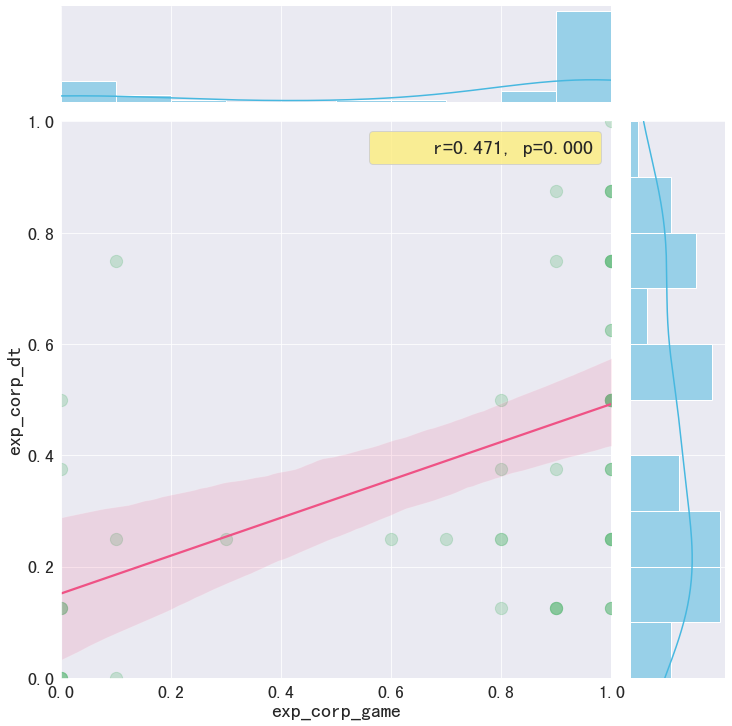

,exp_corp_game,exp_corp_dt
count,59.00,59.00
mean,0.75,0.41
std,0.39,0.28
min,0.00,0.00
25%,0.75,0.12
50%,1.00,0.38
75%,1.00,0.62
max,1.00,1.00


In [14]:
# exp_corp
# 對比關鍵題：以選擇放下的完整答案做為比較
# df_key = data[data.itemno.str.contains('A_3') | data.itemno.str.contains('A_4')]


df1 = df_mg4[['userid','exp_corp_game','exp_corp_dt']]
df1 = df1.dropna()

xlim = [0,1]
ylim = [0,1]
get_jointplot(df = df1 ,x = 'exp_corp_game',y ='exp_corp_dt',xlim = xlim, ylim= ylim )

#### 受試者資料的分布情形、離散的程度與是否偏態。

D:\Users\ian_fang\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Users\ian_fang\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Users\ian_fang\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for hist

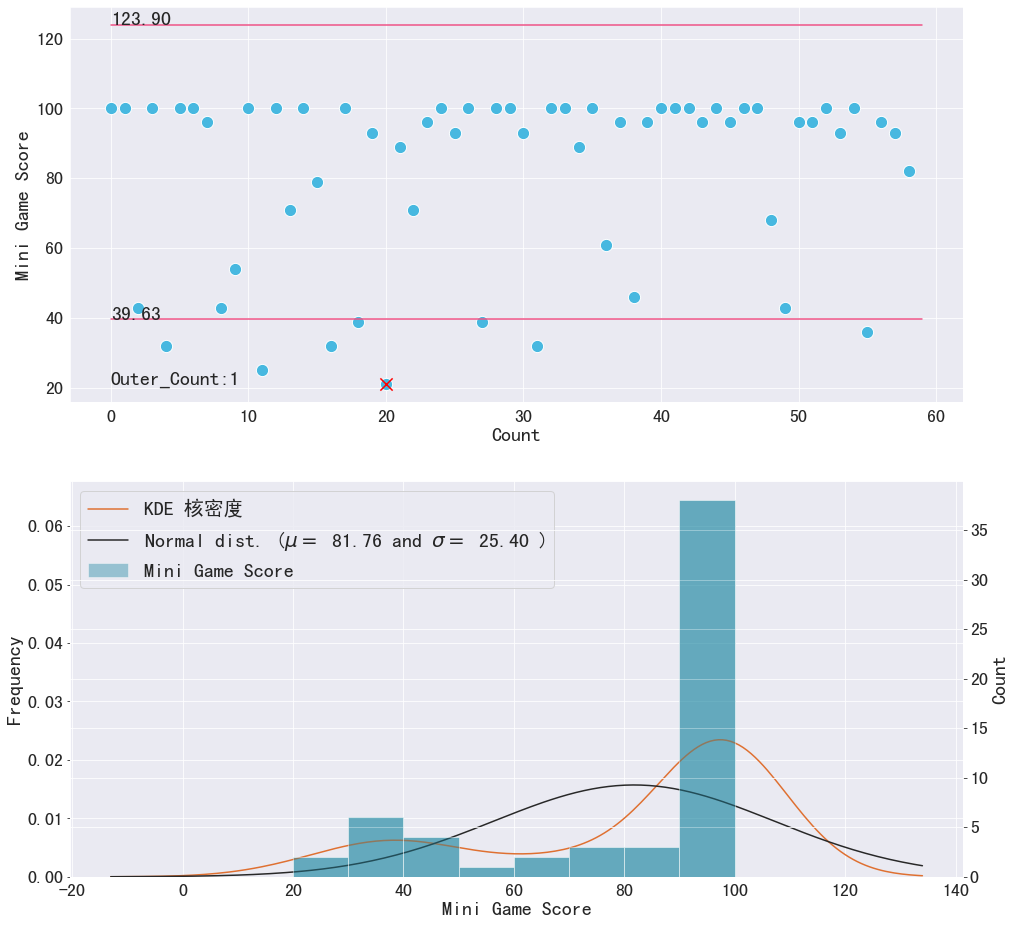

mean: 81.76271186440678 std: 25.614744530183803 median: 96.0
kstest:statistic =  0.31362974354985423 ,pvalue: 1.1762064313294531e-05 「非」常態分佈
KstestResult(statistic=0.31362974354985423, pvalue=1.1762064313294531e-05)
kurtosis: -0.23701367039021992 低闊峰
skew: -1.1741172068000822 左偏
NormaltestResult(statistic=11.320679196879519, pvalue=0.003481334441698152) 「不符合」常態分佈


In [32]:

df = df_mg4.copy()
df.rename(columns={"mngs": "Mini Game Score"},inplace = True)
# df.rename(columns = {"mngs":"Mini_Game_Score"})

df1 = df.loc[:,'Mini Game Score']

bins =  [x for x in range(0,101,10)]
df1 = df1.dropna().reset_index(drop = True)
get_normality_test(df1,ax0_name = 'Mini Game Score', bins = bins)

In [29]:
df1 = df_mg4[['userid','mngs_a','mngs_b']]
df1 = df1.dropna()

df1.query('mngs_a ==100 & mngs_b ==100').count()

userid    24
mngs_a    24
mngs_b    24
dtype: int64

D:\Users\ian_fang\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
D:\Users\ian_fang\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


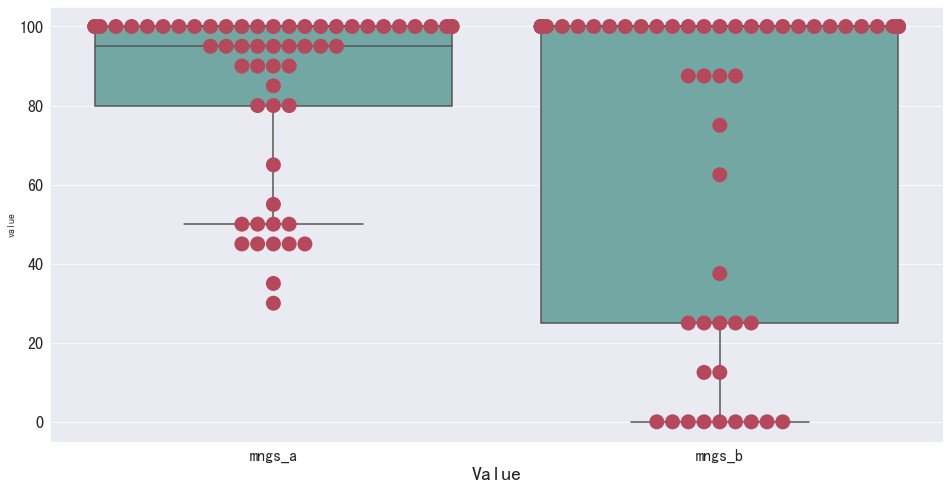

shapiro常態檢定-> wilk: 0.7738043069839478 p_value: 3.3653442445963355e-12 資料「不」符合常態分佈
levene同質性檢定-> statistic: 5.1707971118022655 p_value: 0.024808757846594896 資料間「不」同質，來自不同母體
f_oneway-> f_value: 4.818075259410886 p_value 0.030154407518251155


,df,sum_sq,mean_sq,F,PR(>F)
C(variable),1.00,5090.04,5090.04,4.82,0.03
Residual,116.00,122547.88,1056.45,nan,nan


Anova分析 -> p_value: 0.030154407518251828 組間「有」顯著差異


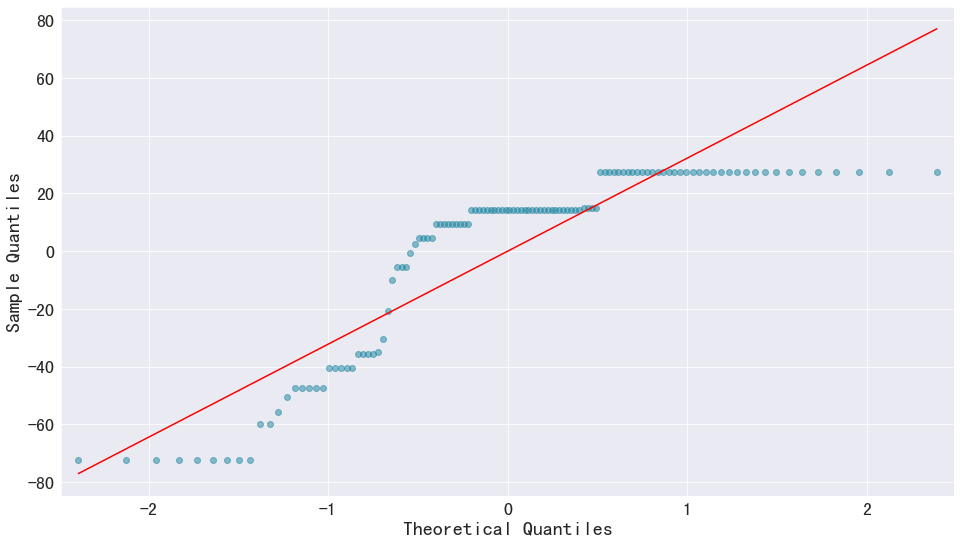

In [30]:
df1 = df_mg4[['userid','mngs_a','mngs_b']]
df1 = df1.dropna()

get_anova(df1)